In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [ ]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [ ]:
#@title create dataset


target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)


class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels, train=True):

        self.base_path = base_path

        self.labels = labels
        self.file_names = file_names
        self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)


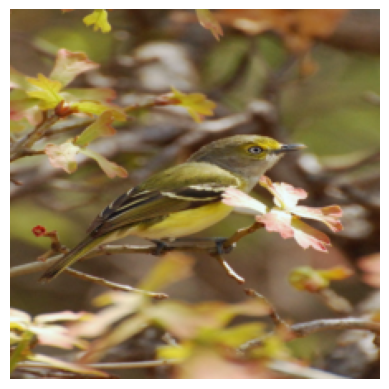

In [ ]:
#@title dataset and dataloader and load a random query from test set

import random

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(29)
data_indices = random.sample(range(test_dataset.__len__()), 1)

for counter, data_idx in enumerate(data_indices):

  query, query_label, query_mask = test_dataset.__getitem__(data_idx)

plt.figure(1)
plt.imshow(imsc(query))
plt.axis('off')
plt.show()


In [ ]:
#@title load model and precomputed prototypes

from transformers import CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')

all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')

IMG_SIZE = 224
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
LATENT_DIM = all_prototype_clf_tokens.shape[-1]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
#@title find closest prototypes

from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)


In [ ]:
#@title functions for getting segments and keypoints in image

from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

def get_segments(embedding, mask, number_of_patches: int,
                 resize_size: int = 64, number_of_segments: int = 8):

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size))

    mask = resize(mask, (resize_size, resize_size), order=0)

    segments = slic(embedding, n_segments=number_of_segments, mask=mask)

    return segments

def get_keypoints(segments, resize_size: int = 64, image_size: int = 224):

    low_res_keypoints = np.zeros_like(segments)
    low_res_segments_properties = regionprops(segments)

    for segment_i, properties_i in enumerate(low_res_segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = segment_i+1

    keypoints = np.zeros((image_size, image_size), dtype=np.int32)

    high_res_keypoints = resize(low_res_keypoints, (image_size, image_size), order=0)
    segments_properties = regionprops(high_res_keypoints)

    for segment_i, properties_i in enumerate(segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        keypoints[x_coordinate, y_coordinate] = segment_i+1

    return keypoints

In [ ]:
#@title find all keypoints in each image

all_keypoints = []
all_segments = []

embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
masks = np.concatenate((query_mask[None, :, :], prototype_masks))

for embedding, mask in zip(embeddings, masks):
    all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

for segment_i in all_segments:
    all_keypoints.append(get_keypoints(segment_i))


In [ ]:
#@title function for getting segment representation

def get_segment_representation(segments, embedding, number_of_patches: int,
                               latent_dimensionality: int, resize_size: int = 64):

    segment_representations = []

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size)).reshape(-1, latent_dimensionality)

    for segment_i in np.unique(segments)[1:]:
        segment_i_indices = np.where(segments.flatten()==segment_i)[0]
        segment_representations.append(np.mean(embedding[segment_i_indices], 0, keepdims=True))

    return np.concatenate(segment_representations), len(np.unique(segments)[1:])


In [ ]:
#@title find mean representation of each region

all_segments_representation = []
number_of_segments = []

for segment, embedding in zip(all_segments, embeddings):
    segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
    all_segments_representation.append(segments_representation)
    number_of_segments.append(number_of_segments_i)


In [ ]:
#@title function for getting mutual nns

def get_mutual_nns(representations: torch.Tensor, number_of_segments: List):

    query_representation = representations[0]
    prototype_representations = np.concatenate(representations[1:])

    nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=1, metric='cosine')
    nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=0, metric='cosine')

    best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_segments[0])
    best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_segments[1:]))

    #best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
    #best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

    return best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes

In [ ]:
#@title find mutual nns

best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)


In [ ]:
#@title function for making prediction

def get_prediction(prototype_matches, prototype_labels, number_of_segments: List, number_of_prototypes: int = 5):

    number_of_matches = []
    for number_of_segments_index in range(len(number_of_segments)-1):
        lower_bound = np.int32(np.sum(number_of_segments[:number_of_segments_index]))
        upper_bound = np.int32(np.sum(number_of_segments[:(number_of_segments_index+1)]))
        number_of_matches.append(np.sum(prototype_matches[lower_bound:upper_bound]))

    number_of_matches = np.array(number_of_matches)
    total_number_of_matches = np.sum(number_of_matches)
    predictions = {}

    for label_i in torch.unique(prototype_labels):
        label_indices = np.where(label_i == prototype_labels)[0]
        predictions[label_i.item()] = np.sum(number_of_matches[label_indices]) / total_number_of_matches

    return predictions

predictions = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
prediction = max(predictions, key=predictions.get)
print(predictions, prediction)

{155: np.float64(0.8571428571428571), 156: np.float64(0.14285714285714285)} 155


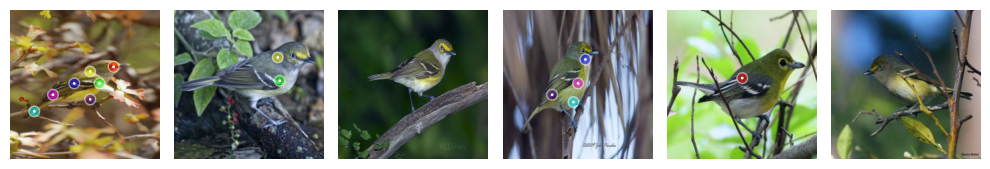

In [ ]:
#@title plot matching keypoints

color_names = ["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"]
cmap = ListedColormap(color_names)

colors = np.array([cmap(x) for x in range(15)])
mnn_matches = {}

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+1, figsize=(10, 5))

inputs = torch.cat([query.to(device).unsqueeze(0), prototypes])

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1

    for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

        if col_idx == 0:
          if not best_buddies_query[keypoint_i-1]: continue
        elif col_idx == 1:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_segments[:col_idx-1])+keypoint_i-1]: continue

        if col_idx == 0:
          color_value = keypoint_counter
          mnn_matches[keypoint_i-1] = color_value
        elif col_idx == 1:
          color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
        else:
          color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_segments[:col_idx-1])+keypoint_i-1]]

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)


fig.tight_layout()

In [ ]:
labels_with_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
number_of_label_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
prototypes_with_matches = {}

for prototype_count, (keypoints_i, prototype_label) in enumerate(zip(all_keypoints[1:], prototype_labels)):
    number_of_matches = 0
    for keypoint_i in np.unique(keypoints_i)[1:]:

        if prototype_count == 0:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(prototype_count)])+keypoint_i-1]: continue

        labels_with_matches[prototype_label.item()] += 1
        number_of_matches += 1

        if number_of_matches > 0:
          number_of_label_matches[prototype_label.item()] += 1

    if number_of_matches > 0:
      prototypes_with_matches[prototype_count] = 1

total_number_of_matches = sum(labels_with_matches.values())
labels_with_matches = {k: v for k, v in sorted(labels_with_matches.items(), key=lambda item: item[1], reverse=True)}

print(total_number_of_matches)
print(labels_with_matches)
print(prototypes_with_matches)
print(number_of_label_matches)

NameError: name 'number_of_prototype_regions' is not defined

In [ ]:

number_of_rows = len(labels_with_matches)
number_of_columns = max(number_of_label_matches.values()) + 1

fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(3*number_of_columns, 3*number_of_rows), squeeze=False)

axs[0, 0].set_title('Query')
for ax in axs.ravel(): ax.set_axis_off()

for row_idx, label_i in enumerate(labels_with_matches.keys()):

    axs[row_idx, 0].imshow(imsc(inputs[0]))

    indices_of_labels = list(np.where((prototype_labels == label_i))[0])

    for label_index in indices_of_labels:
        if not label_index in list(prototypes_with_matches.keys()):
            indices_of_labels.remove(label_index)

    indices_of_labels = [index_of_label+1 for index_of_label in indices_of_labels]

    span_of_indices_of_lables = []
    for index_of_label in indices_of_labels:
        upper_bound = np.sum(number_of_prototype_regions[:(index_of_label)])
        lower_bound = upper_bound-np.sum(number_of_prototype_regions[(index_of_label-1):(index_of_label)])

        for i in range(lower_bound, upper_bound):
            span_of_indices_of_lables.append(i)

    indices_of_labels.insert(0, 0)

    all_keypoints_row_i = [all_keypoints[i] for i in indices_of_labels]

    for col_idx, (index_of_label, keypoints_i) in enumerate(zip(indices_of_labels, all_keypoints_row_i)):

        axs[row_idx, col_idx].imshow(imsc(inputs[index_of_label]))
        axs[row_idx, col_idx].set_axis_off()

        radius1, radius2 = 8, 1

        for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

            if index_of_label == 0:
              if not best_buddies_query[keypoint_i-1]: continue
            elif index_of_label == 1:
              if not best_buddies_prototypes[keypoint_i-1]: continue
            else:
              if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(index_of_label-1)])+keypoint_i-1]: continue

            if index_of_label == 0 and not nearest_neighbor_query[keypoint_i-1] in span_of_indices_of_lables: continue

            if index_of_label == 0:
              color_value = keypoint_counter
              mnn_matches[keypoint_i-1] = color_value
            elif index_of_label == 1:
              color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
            else:
              color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_prototype_regions[:(index_of_label-1)])+keypoint_i-1]]

            y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

            circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
            circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
            axs[row_idx, col_idx].add_patch(circ1_1)
            axs[row_idx, col_idx].add_patch(circ1_2)


In [ ]:
#@title Evaluate on test set

import random

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(31)
data_indices = random.sample(range(test_dataset.__len__()), 1000)
hits = []

for counter, data_idx in enumerate(data_indices):

    query, query_label, query_mask = test_dataset.__getitem__(data_idx)

    indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
    prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

    all_keypoints = []
    all_segments = []

    embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
    masks = np.concatenate((query_mask[None, :, :], prototype_masks))

    for embedding, mask in zip(embeddings, masks):
      all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

    for segment_i in all_segments:
      all_keypoints.append(get_keypoints(segment_i))

    all_segments_representation = []
    number_of_segments = []

    for segment, embedding in zip(all_segments, embeddings):
        segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
        all_segments_representation.append(segments_representation)
        number_of_segments.append(number_of_segments_i)

    best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)

    predictions = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
    prediction = max(predictions, key=predictions.get)

    hits.append((prediction == query_label))

    print(counter, hits[-1], np.sum(hits)/len(hits))

1.0
0 True None
1.0
1 True None
1.0
2 True None
1.0
3 True None
0.8
4 False None
0.8333333333333334
5 True None
0.8571428571428571
6 True None
0.875
7 True None
0.8888888888888888
8 True None
0.9
9 True None
0.8181818181818182
10 False None
0.8333333333333334
11 True None
0.8461538461538461
12 True None
0.8571428571428571
13 True None
0.8666666666666667
14 True None
0.875
15 True None
0.8823529411764706
16 True None
0.8888888888888888
17 True None
0.8947368421052632
18 True None
0.9
19 True None
0.9047619047619048
20 True None
0.8636363636363636
21 False None
0.8695652173913043
22 True None
0.875
23 True None
0.88
24 True None
0.8846153846153846
25 True None
0.8888888888888888
26 True None
0.8928571428571429
27 True None
0.896551724137931
28 True None
0.9
29 True None
0.9032258064516129
30 True None
0.90625
31 True None
0.9090909090909091
32 True None
0.8823529411764706
33 False None
0.8857142857142857
34 True None
0.8888888888888888
35 True None
0.8648648648648649
36 False None
0.8421

In [ ]:
from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

In [ ]:
#@title keypoint counting classifier class

import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from typing import List, Tuple

def get_number_of_patches_and_dim(model: nn.Module, image_size: int) -> Tuple[int, int]:

    dummy_input = torch.zeros(1, 3, image_size, image_size, device='cuda')
    outputs = model(dummy_input)
    _, number_of_patches, token_dimensionality = outputs.last_hidden_state.shape
    return number_of_patches-1, token_dimensionality


@dataclass
class Keypoint_Counting_Classifier:
    vit: nn.Module
    prototype_clf_tokens: torch.Tensor
    number_of_prototypes: int
    number_of_classes: int
    image_size: int
    path_to_prototype_resources: str
    device: str='cuda'

    def __post_init__(self):

        self.vit.eval()
        self.vit = self.vit.to(self.device)

        self.number_of_patches, self.token_dimensionality = get_number_of_patches_and_dim(self.vit, self.image_size)

    def predict(self, query):

        query = query.unsqueeze(0).to(self.device)

        prototype_dict = self.prepare_prototypes(query)

    def predcit_and_viz(self):
        pass

    def prepare_prototypes(self, query):

        query_clf_token = self.vit(query).pooler_output
        similarity = cosine_similarity(query_clf_token, self.prototype_clf_tokens)
        top_k_similar_prototypes_indices = torch.topk(similarity, self.number_of_prototypes)[1]

        return None

kcc = Keypoint_Counting_Classifier(model, all_prototype_clf_tokens, 5, 200, 224, 'drive/MyDrive/CoSegXAI/')
out = kcc.predict(query)

In [ ]:
all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')